In [117]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

# plt.style.use('seaborn')
%matplotlib inline

In [118]:
# вспомогательная функция
def plot_one_image(src_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение.
    
    :param src_image: np.ndarray: исходное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 1, figsize=(6*2, 4*2), constrained_layout=True)
    ax1 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    plt.show()

In [119]:
def plot_transform_result(src_image, transform_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение и его преобразование.
    
    :param src_image: np.ndarray: исходное изображение
    :param transform_image: np.ndarray: преобразованное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 2, figsize=(6.4*2, 4.8*2), constrained_layout=True)
    ax1, ax2 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    ax2.set_title('Результат преобразования')
    ax2.imshow(transform_image, cmap=cmap)
    ax2.set_xticks([]), ax2.set_yticks([])
    plt.show()

In [186]:
def zero_pad(image, pad_height, pad_width):
    """ Zero-pad an image.

    Ex: a 1x1 image [[1]] with pad_height = 1, pad_width = 2 becomes:

        [[0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0]]         of shape (3, 5)

    Args:
        image: numpy array of shape (H, W).
        pad_width: width of the zero padding (left and right padding).
        pad_height: height of the zero padding (bottom and top padding).

    Returns:
        out: numpy array of shape (H+2*pad_height, W+2*pad_width).
    """

    out = image.copy()
    
    z = np.zeros([pad_height, out.shape[1]])
    out = np.r_[z.copy(), out, z.copy()]

    z = np.zeros([out.shape[0], pad_width])
    out = np.c_[z.copy(), out, z.copy()]
    return out


In [185]:
def conv_faster(image, kernel):
    """
    :param image: изображение 
    :param kernel: ядро
    :return: свертка
    """
    
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    
    im = zero_pad(image, Hk // 2, Wk//2)
    
    Hi, Wi = im.shape
    kern = np.r_[kernel, np.zeros([Hi-Hk, Wk])]
    kern = np.c_[kern, np.zeros([kern.shape[0] ,Wi-Wk])]

    fim = np.fft.fft2(im)  
    fim = np.fft.fftshift(fim) 
    fkern = np.fft.fft2(kern)  
    fkern = np.fft.fftshift(fkern)  
    
    fout = fim*fkern
     
    out = np.fft.ifftshift(fout)  
    out = np.fft.ifft2(out)
    out = np.real(out)
    
    out = np.delete(out, range(Wk-kernel.shape[1]%2), 1)  
    out = np.delete(out, range(Hk-kernel.shape[0]%2), 0)
    
    return out.astype(np.int64)

In [346]:
def del_splashes(image, size1=11, size2=13):
    h, w = image.shape
    
    res = image.copy()
    d = (size2-size1)//2
    ny = (h-d)//size1 + int((h-d)%size1 != 0)
    nx = (w-d)//size1 + int((w-d)%size1 != 0)
    laddy = [d, d+size1//4, d+size1//2, d+size1*3//4]
    laddx = [d, d+size1//4, d+size1//2, d+size1*3//4]
    for addy in laddy:
        for addx in laddx:
            for i in range(ny):
                for j in range(nx):
#                     y = i*size2 + size2//2+addy
#                     x = j*size2 + size2//2+addx
                    y = i*size1 + size1//2+addy
                    x = j*size1 + size1//2+addx
                    
                    slice1 = image[y-size1//2 : y+size1//2+1, x-size1//2 : x+size1//2+1].copy()
                    slice2 = image[y-size2//2 : y+size2//2+1, x-size2//2 : x+size2//2+1].copy()

                    hist1 = cv2.calcHist([slice1], [0], None, [255], [0, 255])
                    hist2 = cv2.calcHist([slice2], [0], None, [255], [0, 255])
                    hist = hist2-hist1
                    cols = np.where((hist == 0) & (hist1 != 0))[0]
                    if not len(cols):
                        continue

                    hist1[cols] = 0
                    max_col = np.argmax(hist1)
                    for col in cols:
                        slice1[slice1 == col] = max_col
                    res[y-size1//2 : y+size1//2+1, x-size1//2 : x+size1//2+1] = slice1
    return res

In [358]:
def jackal(image, size=9):
    h, w = image.shape
    
    res = image.copy()
    ny = h//size+1
    nx = w//size+1
    for i in range(ny):
        for j in range(nx):
            y = i*size + size//2
            x = j*size + size//2
                    
            slice1 = image[y-size//2 : y+size//2+1, x-size//2 : x+size//2+1].copy()

            hist1 = cv2.calcHist([slice1], [0], None, [255], [0, 255])
            max_col = np.argmax(hist1)
            slice_jackal = np.ones(slice1.shape)*max_col
            res[y-size//2 : y+size//2+1, x-size//2 : x+size//2+1] = slice_jackal
    return res

In [359]:
def del_cont(image, size=100, inverse=True, col = 0, pad=True):
    im = image.copy()
    if inverse:
        if pad:
            im = np.pad(im, 1, constant_values=col)
        im = np.uint8((im == 0)*255)
    elif pad:
        im = np.pad(im, 1, constant_values=255-col)
    
    h, w = im.shape
    ny = h//size+1
    nx = w//size+1
    laddy = [0, size//4, size//2, size*3//4]
    laddx = [0, size//4, size//2, size*3//4]
    for addy in laddy:
        for addx in laddx:
            for i in range(ny):
                for j in range(nx):
                    slicei = im[i*size+addy:(i+1)*size+1+addy, j*size+addx:(j+1)*size+1+addx]
            #             plot_one_image(slice, is_gray=True)
                    contours, hierarchy = cv2.findContours(slicei.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                    temp = cv2.drawContours(slicei, contours, -1, 255, cv2.FILLED)
                    im[i*size+addy:(i+1)*size+1+addy, j*size+addx:(j+1)*size+1+addx] = temp    
     
    if pad:
        im = np.delete(im, w-1, 1)
        im = np.delete(im, h-1, 0)
        im = np.delete(im, 0, 1)
        im = np.delete(im, 0, 0)
    
    return im

In [399]:
def resize(image, k):
    old_h, old_w = image.shape
    im = image[:old_h - old_h%k, :old_w - old_w%k]
    h, w = im.shape
    print(h, w)

    ny = h//k
    nx = w//k
    res = np.zeros((ny, nx))
    for i in range(ny):
        for j in range(nx):
            y = i*k
            x = j*k
                    
            slice1 = image[y : y+k+1, x : x+k+1].copy()

            hist1 = cv2.calcHist([slice1], [0], None, [255], [0, 255])
            max_col = np.argmax(hist1)
            res[i][j] = max_col
    return res.astype(np.uint8)

In [412]:
def contours(image, count_gauss1 = 1, ksize1=5, g_threshold1 = 150, kresize = 1):
    h, w, _ = image.shape
#     print(image.shape)
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_img = cv2.resize(gray_img.copy(), (w // kresize, h // kresize))
    plot_one_image(gray_img)
#     gray_img = cv2.GaussianBlur(gray_img, ksize=(ksize1, ksize1), sigmaX=1, sigmaY=1)
#     gray_img = cv2.GaussianBlur(gray_img, ksize=(ksize1, ksize1), sigmaX=1, sigmaY=1)
    jackal_size = 9
    gray_img = del_splashes(gray_img, size1 = jackal_size)
#     gray_img = jackal(gray_img, size = jackal_size)
    

    gray_img = resize(gray_img, jackal_size)
    plot_one_image(gray_img)
#     gx = cv2.Sobel(gray_img, cv2.CV_32F, 1, 0, ksize=1)
#     gy = cv2.Sobel(gray_img, cv2.CV_32F, 0, 1, ksize=1)
#     mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
#     round_angle = angle-22.5
#     round_angle[round_angle < 0] = 360+round_angle[round_angle < 0]
#     round_angle = np.int32(round_angle/45)
#     res = np.zeros_like(gray_img)
#     res = cv2.cvtColor(res, cv2.COLOR_GRAY2RGB)
#     for y in range(gray_img.shape[0]):
#         for x in range(gray_img.shape[1]):
#             col = np.array([0, 0, 0])
#             if round_angle[y][x] % 2:
#                 col[2] = 255
#             if round_angle[y][x] % 4 > 1:
#                 col[1] = 255
#             if round_angle[y][x] > 4:
#                 col[0] = 255
#             res[y][x] = col
#     for i in range(8):
#         plot_one_image(round_angle==i)
#     a = (edge != 0) | (mag > 10)
#     values, counts = np.unique(mag, return_counts=True)
# #     plot_one_image(image)
# #     plt.plot(values, counts)
# #     plt.show()
#     plot_one_image(mag)

#     values, counts = np.unique(mag, return_counts=True)
#     a = counts.mean()/2
#     ind = np.argmax(counts) + np.where(counts[np.argmax(counts):] < a)[0][0]
#     max_mag = values[ind]
#     res = np.uint8((mag >= max_mag))
#     kernel = np.ones([3,3])
#     res = conv_faster(res, kernel)
#     res = np.uint8((res > 5)*255)
    
#     res = del_cont(res, 200, True)
#     res = del_cont(res, min(res.shape)//5, True)
#     res = np.uint8((res != 0)*255)
#     values, counts = np.unique(res, return_counts=True)
#     print(values[0], counts[0])
#     print(values[1], counts[1])
    
#     res = cv2.cvtColor(res, cv2.COLOR_GRAY2RGB)
#     cv2.circle(res, (w//2, h//2), 4, (255, 0, 0), thickness=4)

#     plot_one_image(res)
#     return gray_img, res

In [413]:
# def contours(image, size=100, count_gauss1 = 1, ksize1=5, g_threshold1 = 150, kresize = 1):
#     h, w, _ = image.shape
#     ny = h//size+int(h%size!=0)
#     nx = w//size+int(w%size!=0)
#     print(ny, nx)
    
#     gray_img = np.zeros((h, w))
#     res = np.zeros((h, w))
    
#     for i in range(ny):
#         for j in range(nx):
#             im = image[i*size : i*size+size+1, j*size : j*size+size+1]
#             gray_imgi, resi = contoursi(im, count_gauss1 = 1, ksize1=5, g_threshold1 = 150, kresize = 1)
#             gray_img[i*size : i*size+size+1, j*size : j*size+size+1] = gray_imgi
#             res[i*size : i*size+size+1, j*size : j*size+size+1] = resi
#     plot_one_image(gray_img)
#     plot_one_image(res)

450 1050


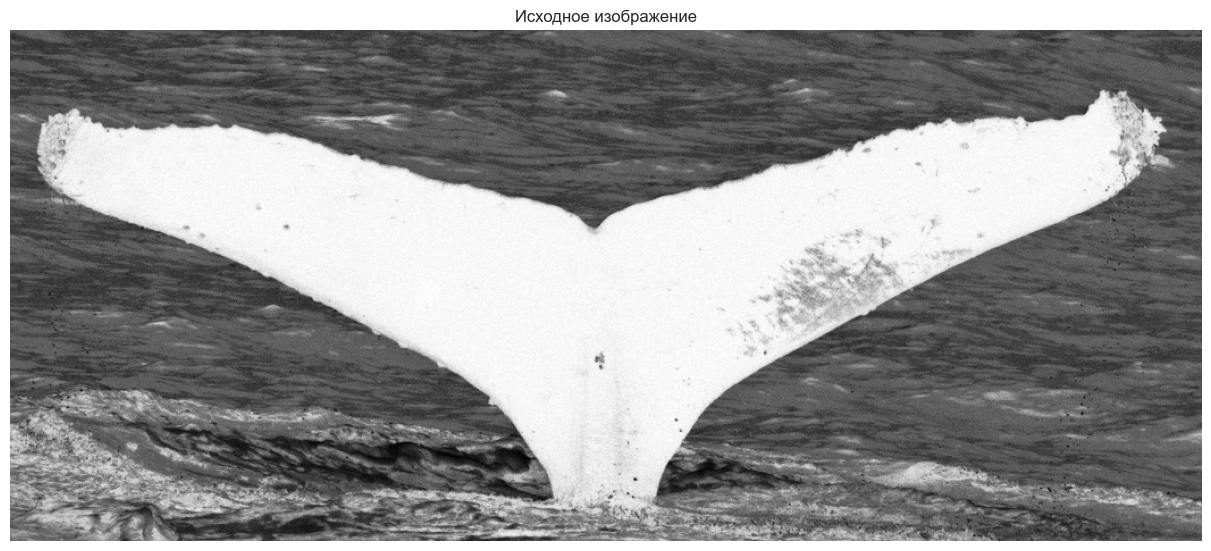

450 1044


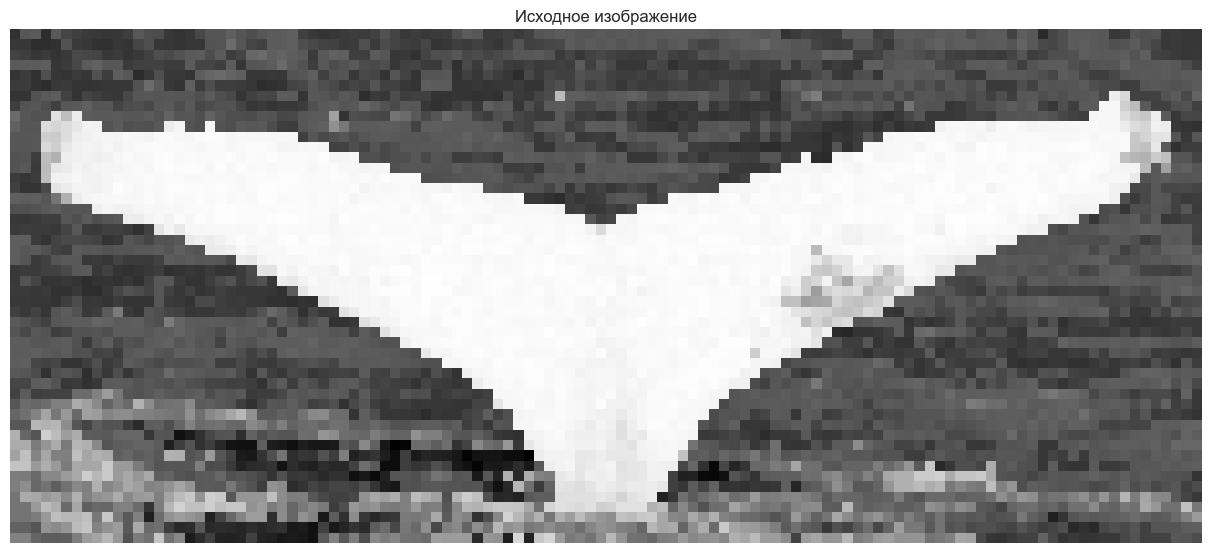

----------------
417 1050


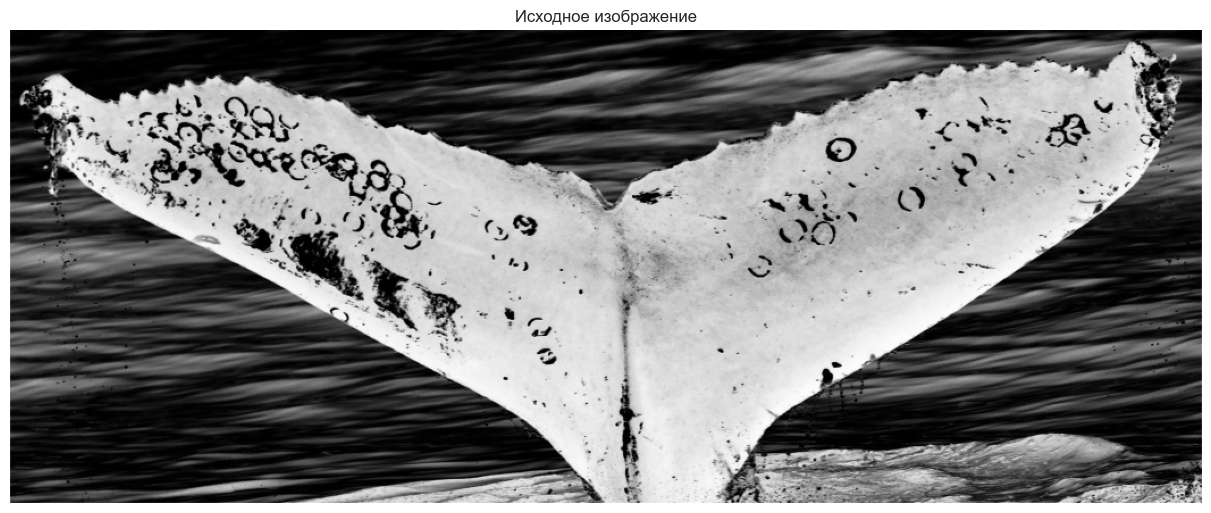

414 1044


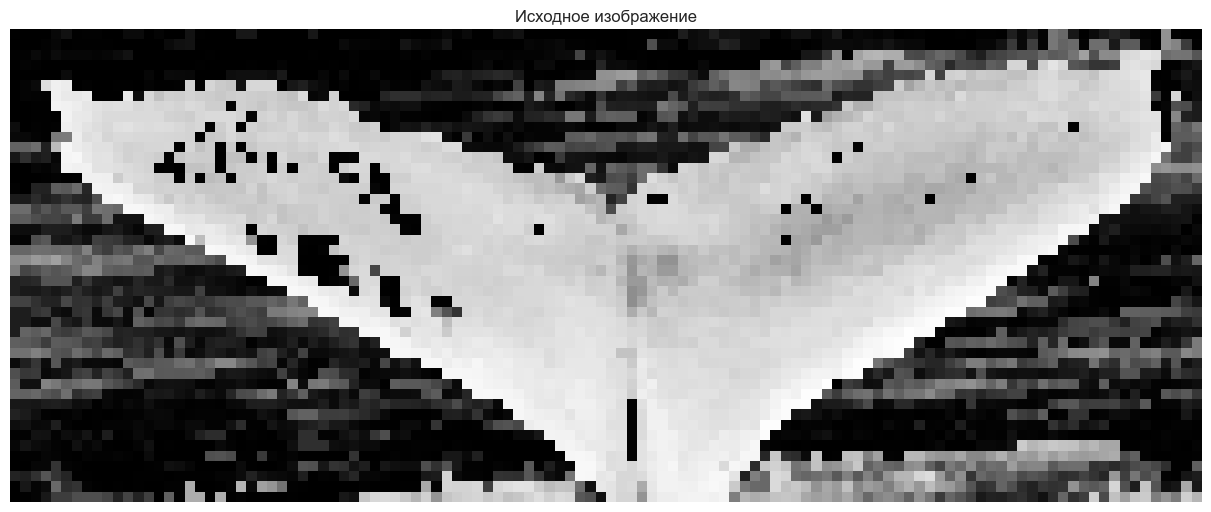

----------------
700 1050


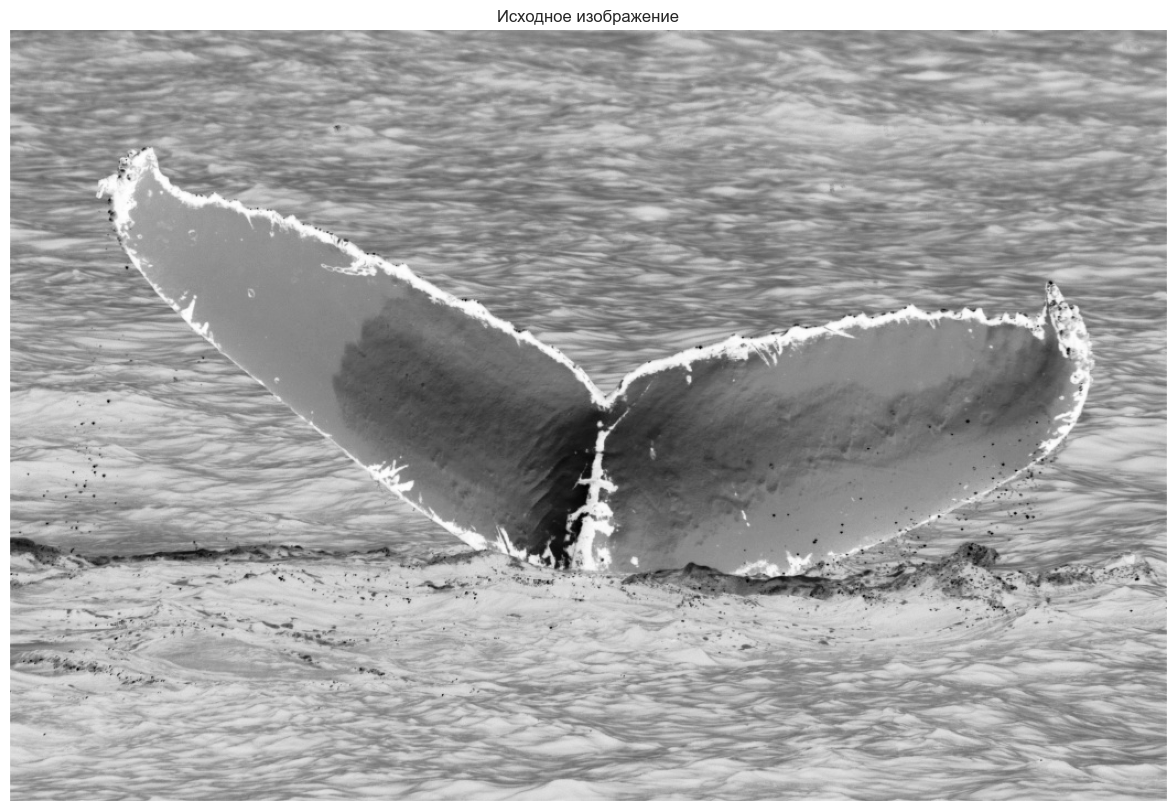

693 1044


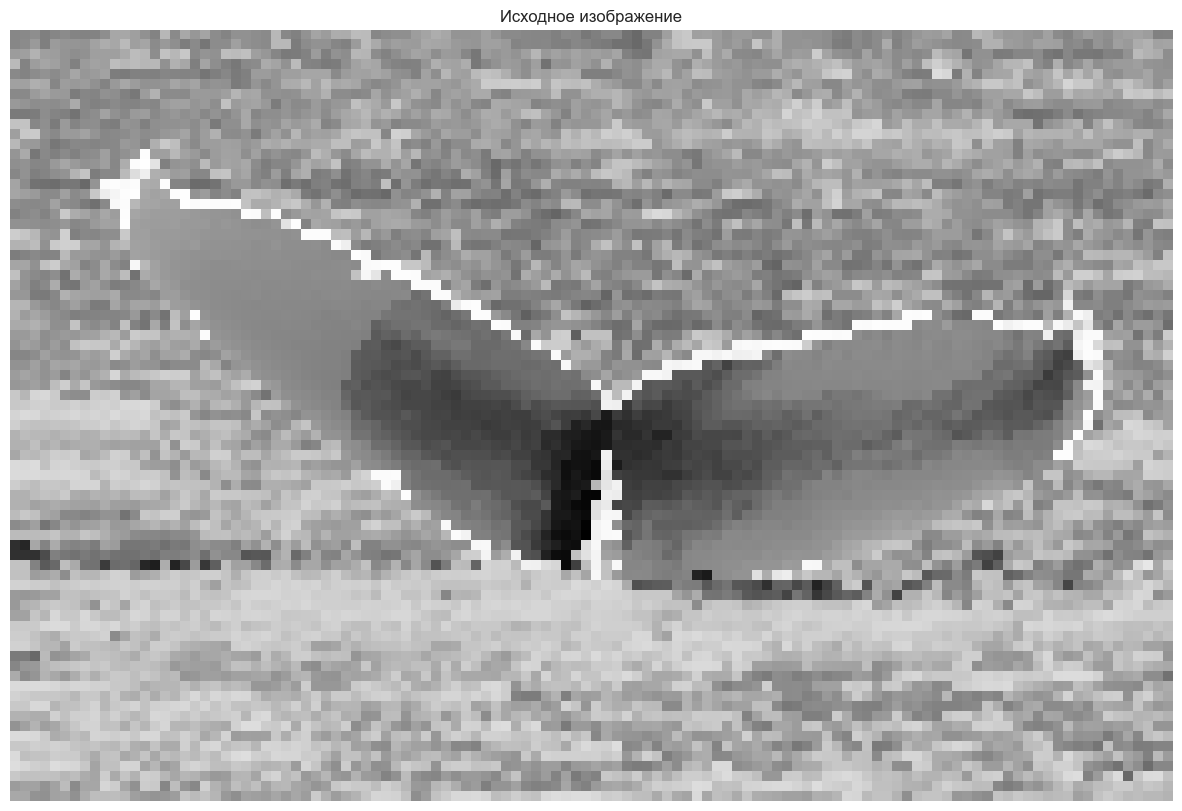

----------------
466 699


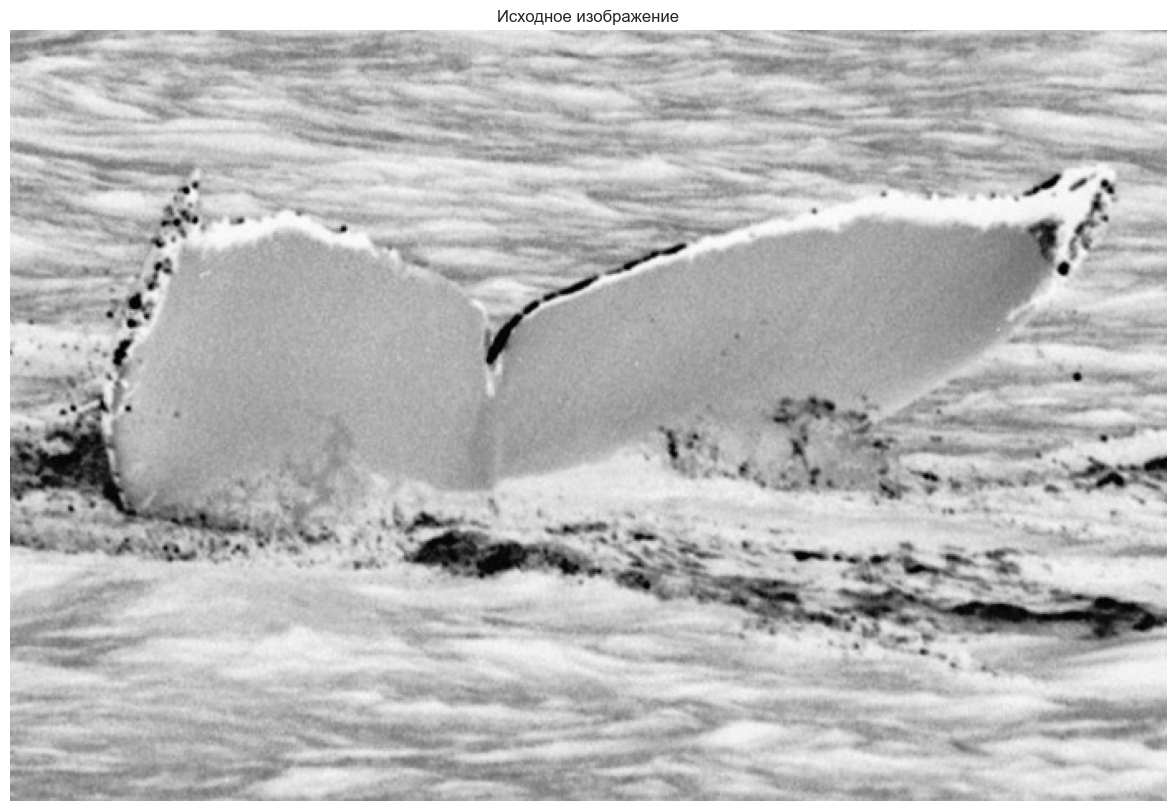

459 693


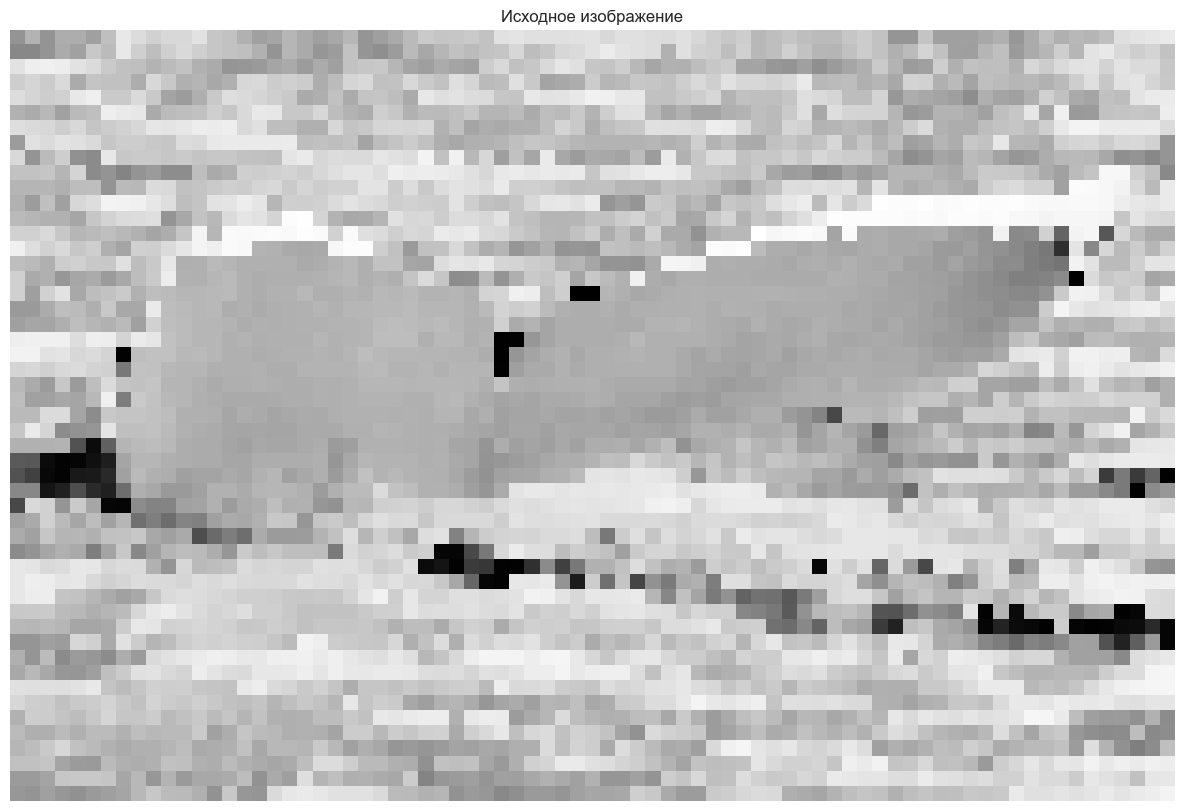

----------------
618 1050


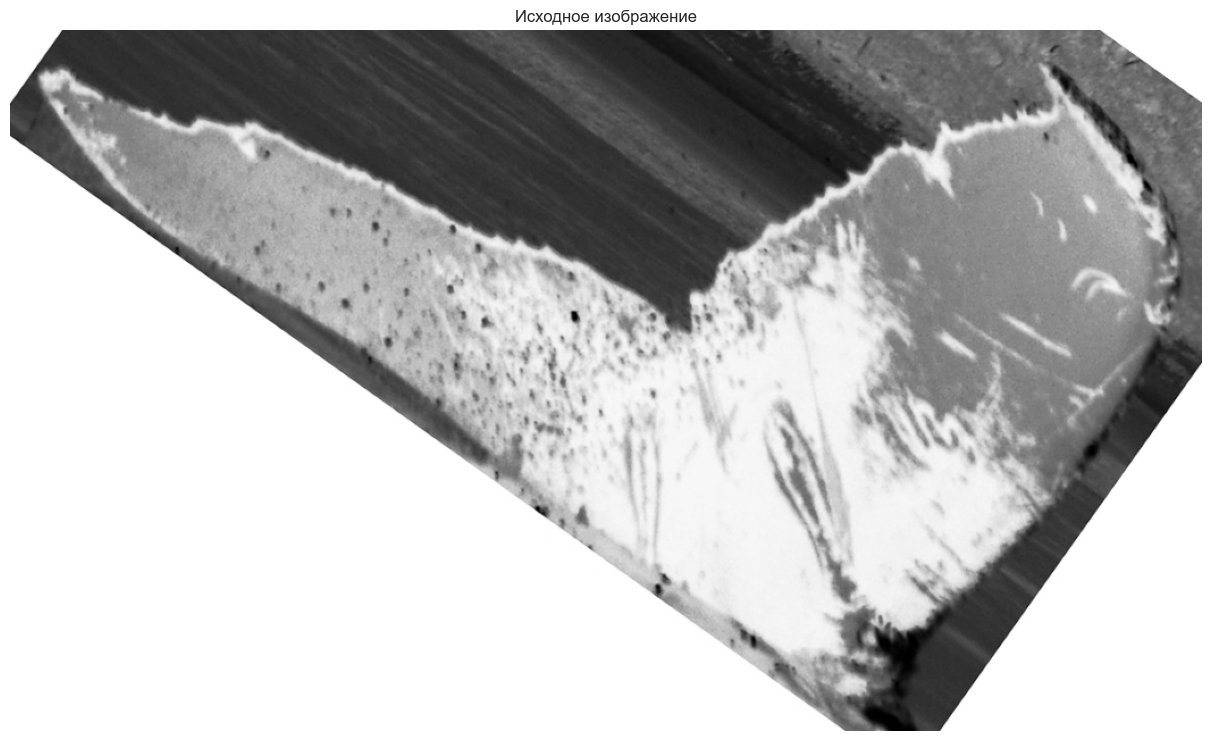

612 1044


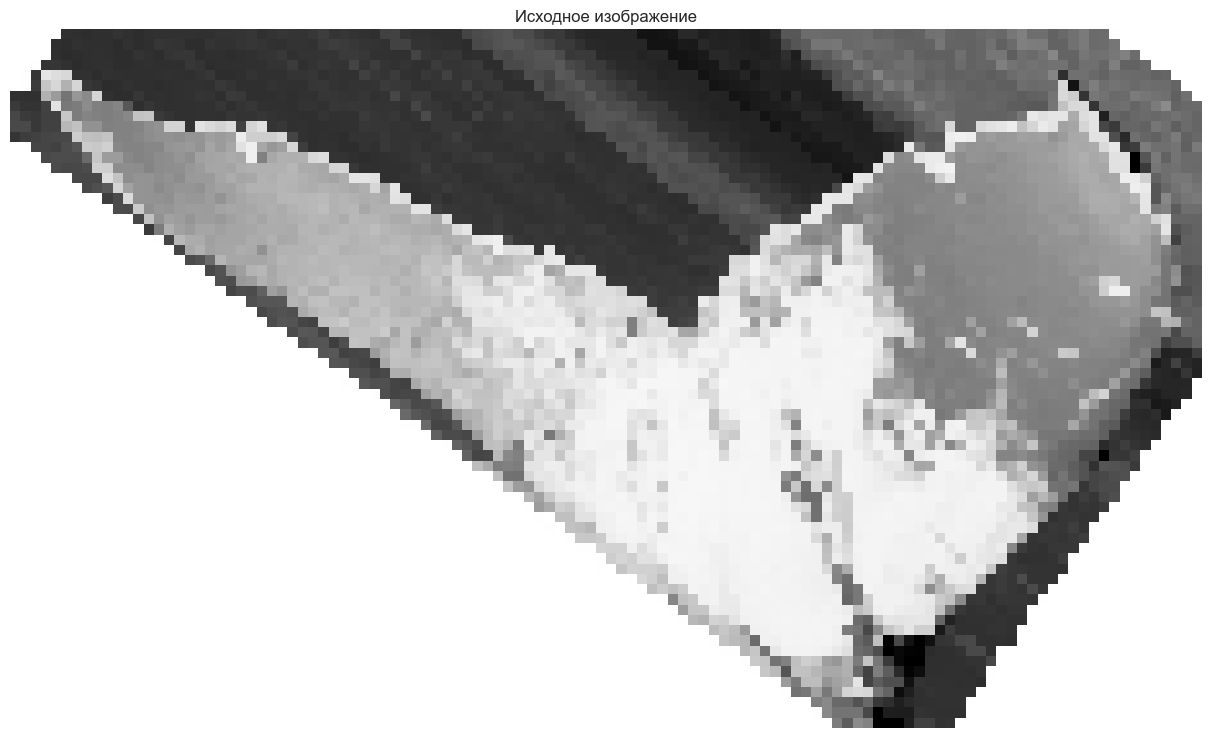

----------------
700 1050


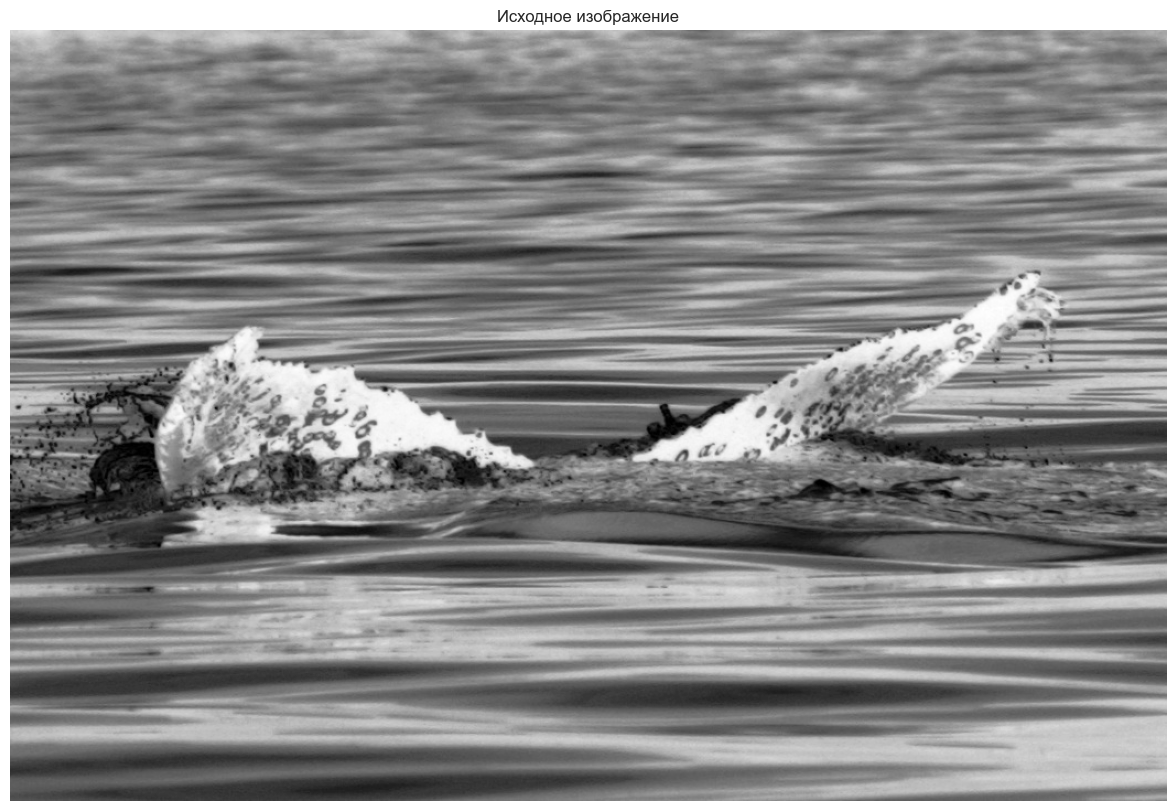

693 1044


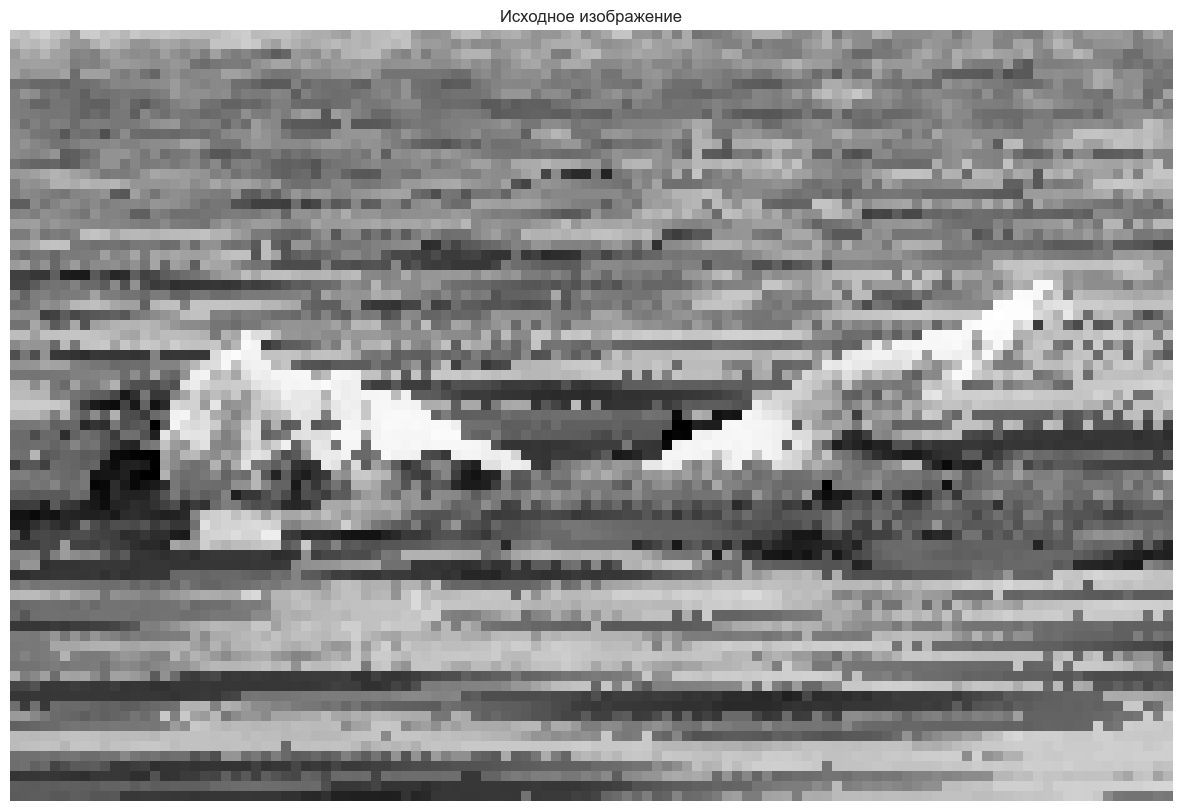

----------------
667 1000


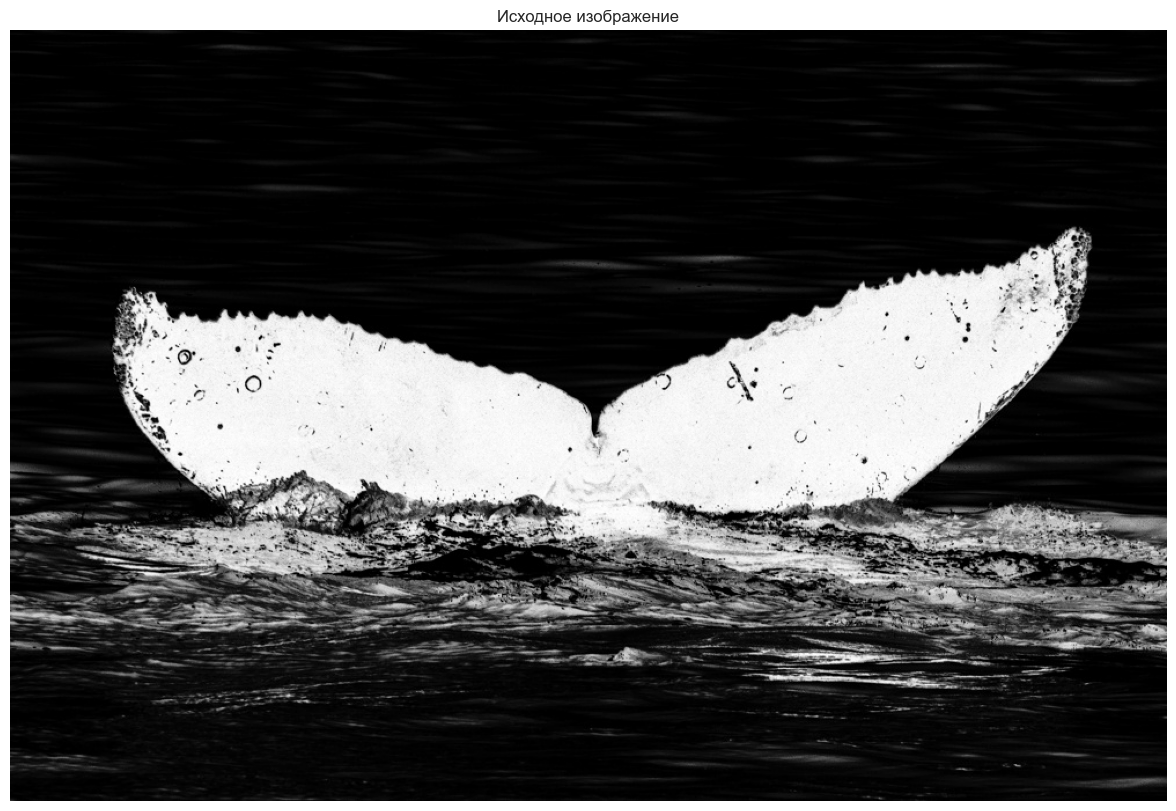

666 999


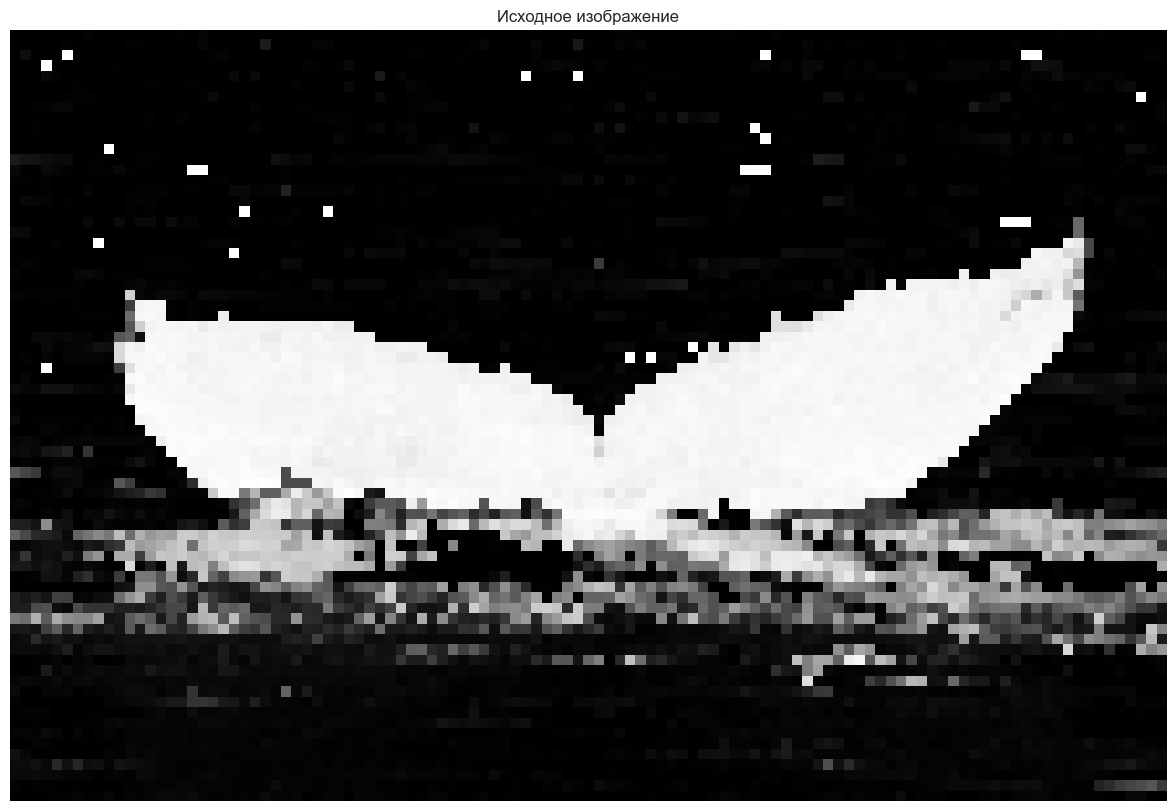

----------------
500 700


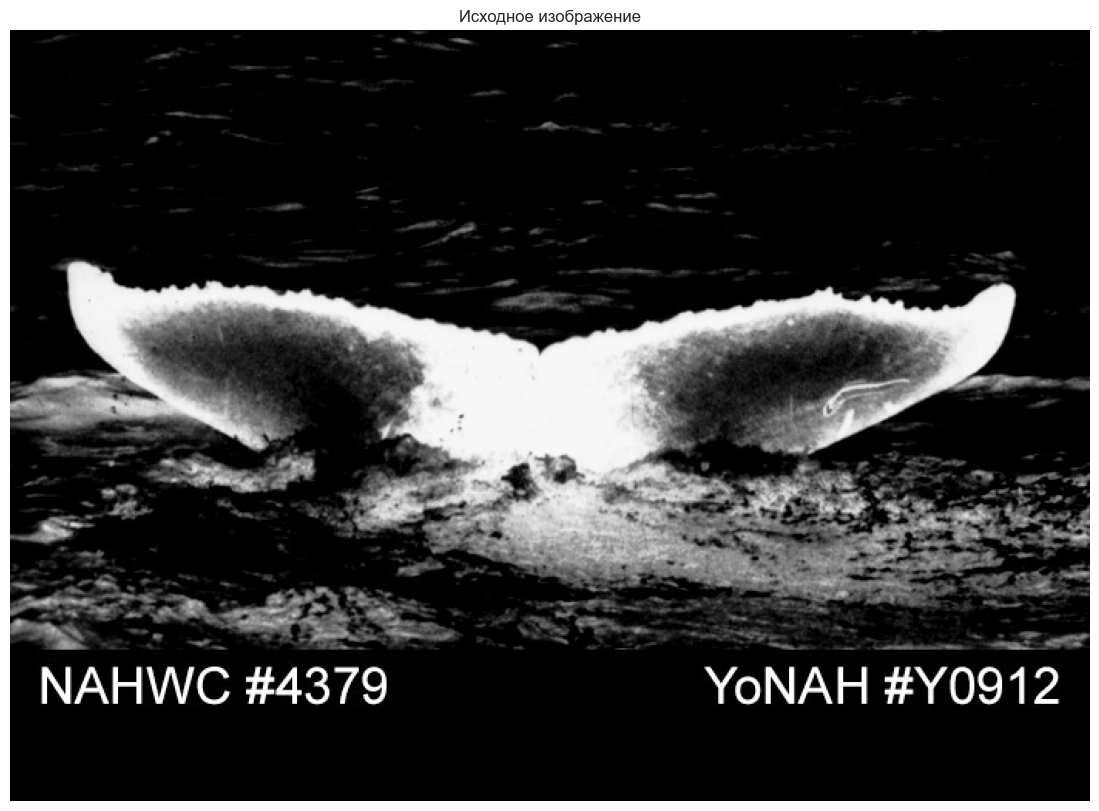

495 693


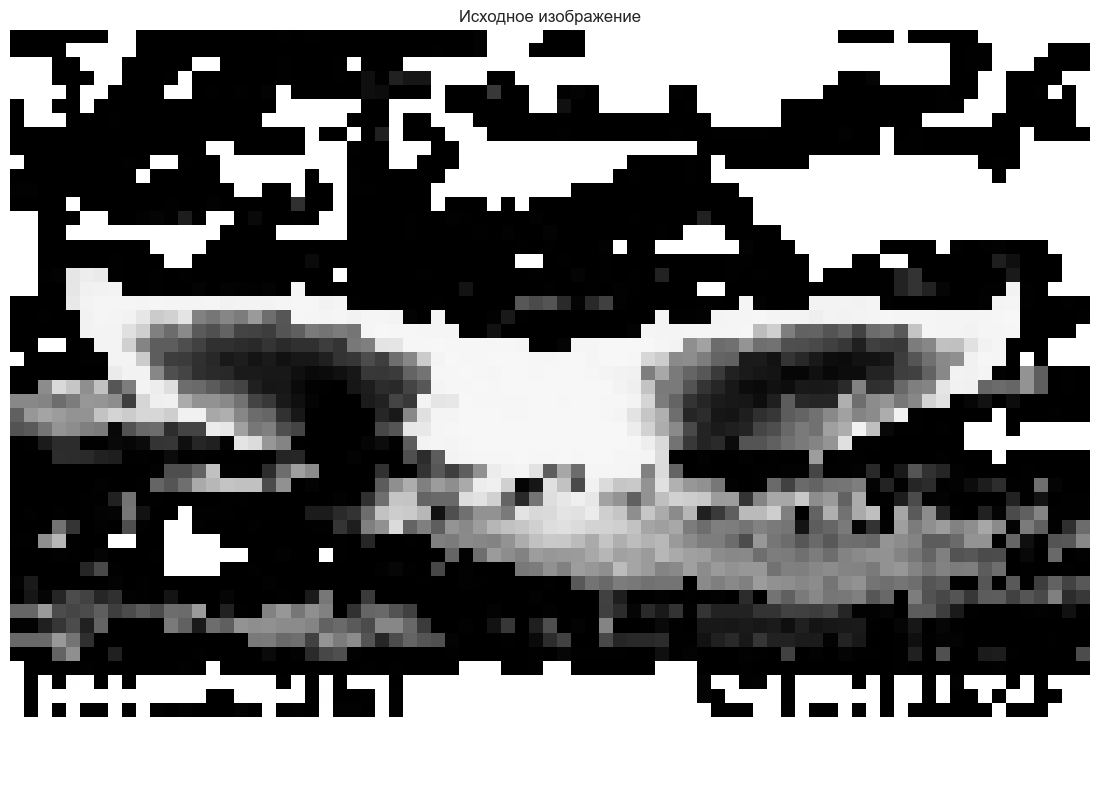

----------------
599 1050


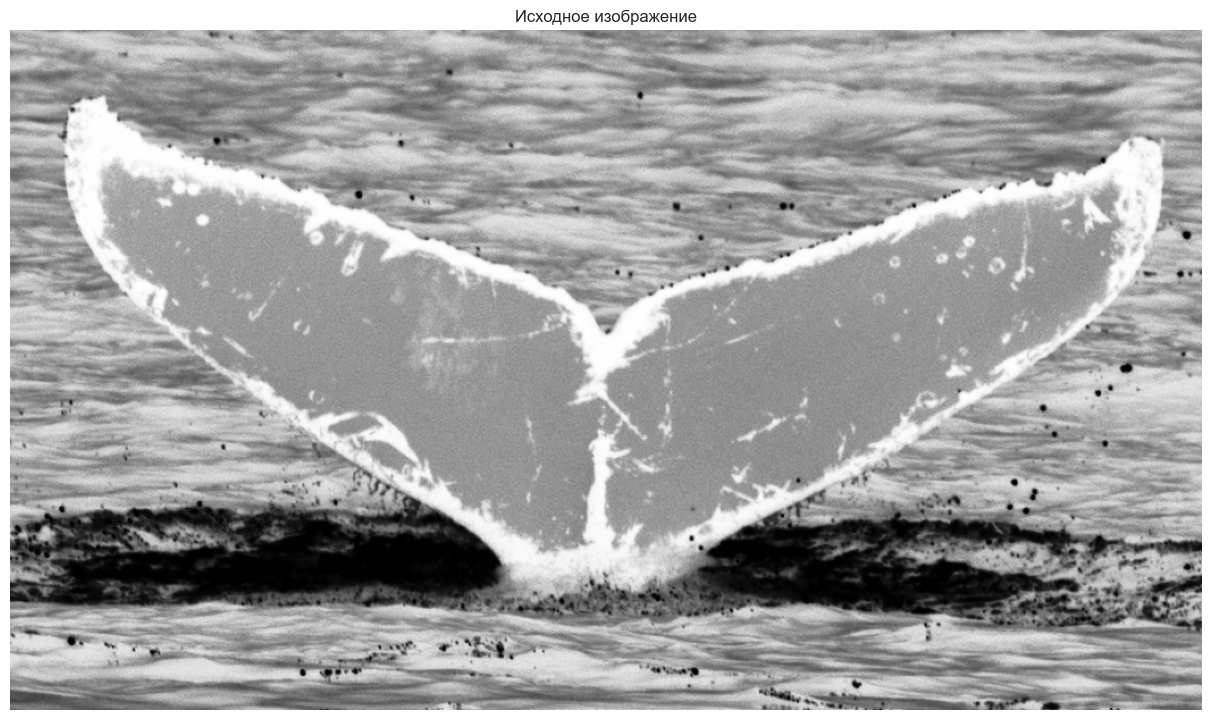

594 1044


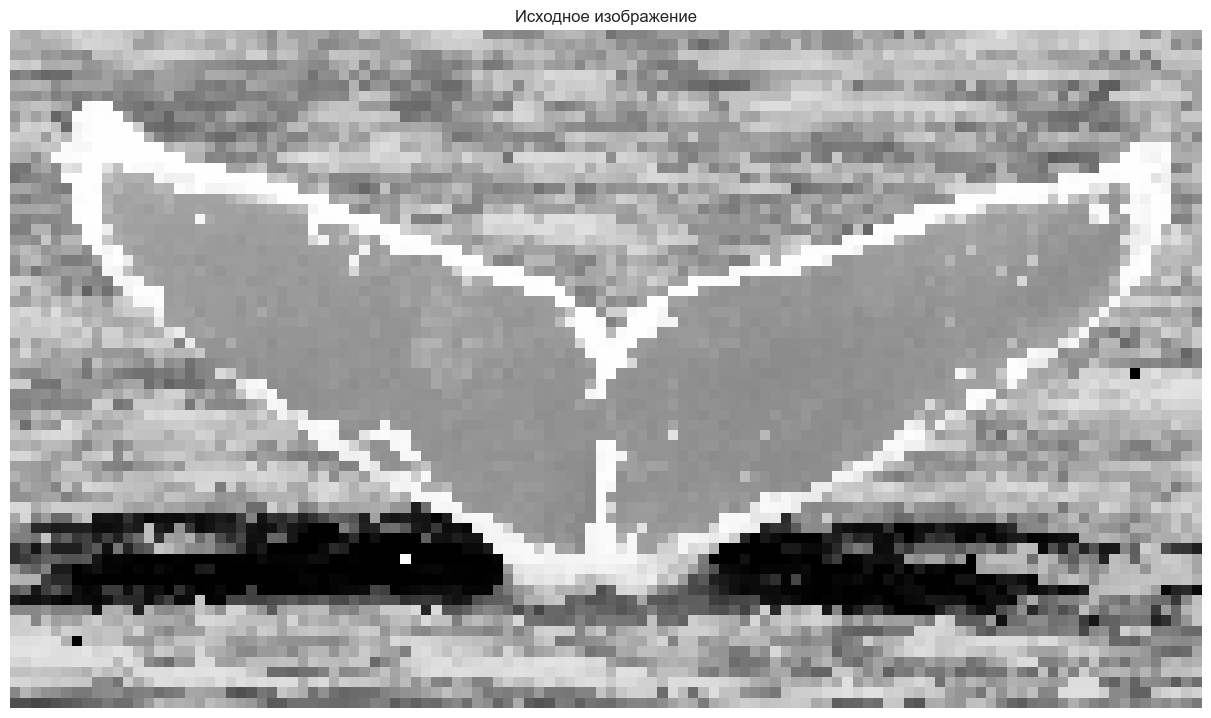

----------------
1032 1050


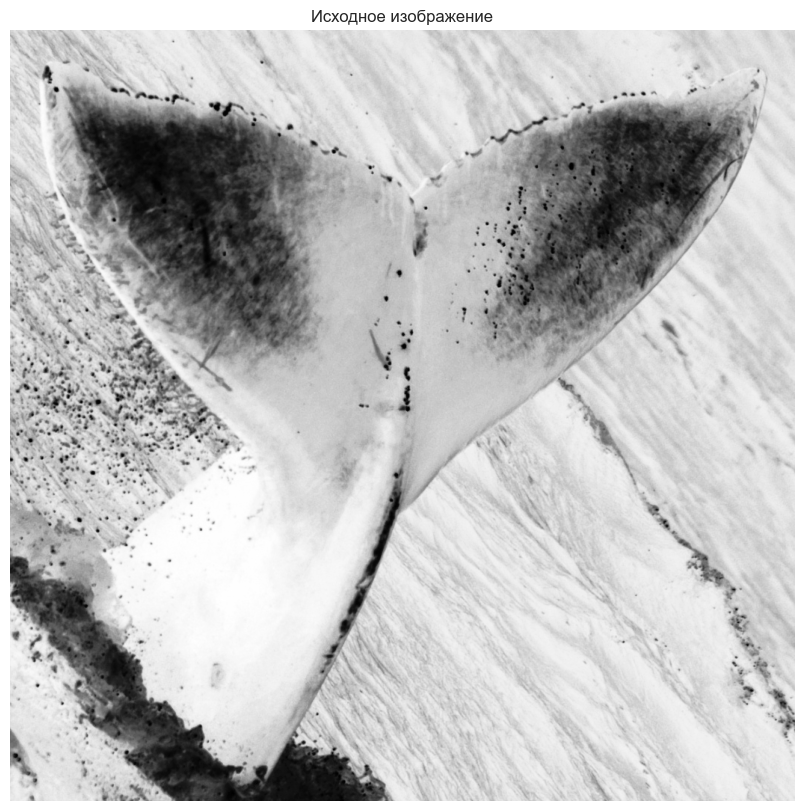

1026 1044


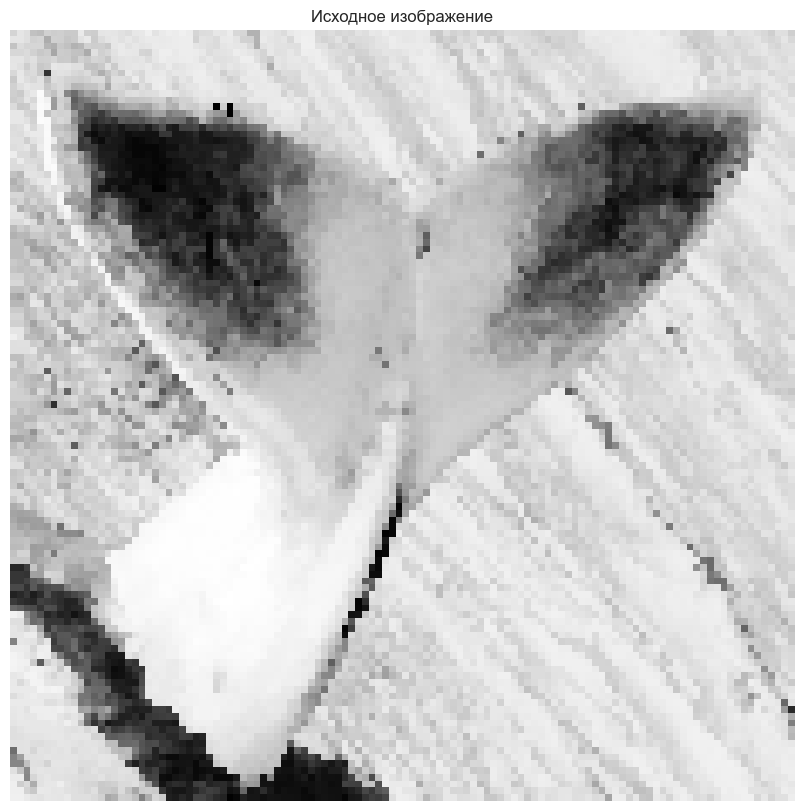

----------------
500 700


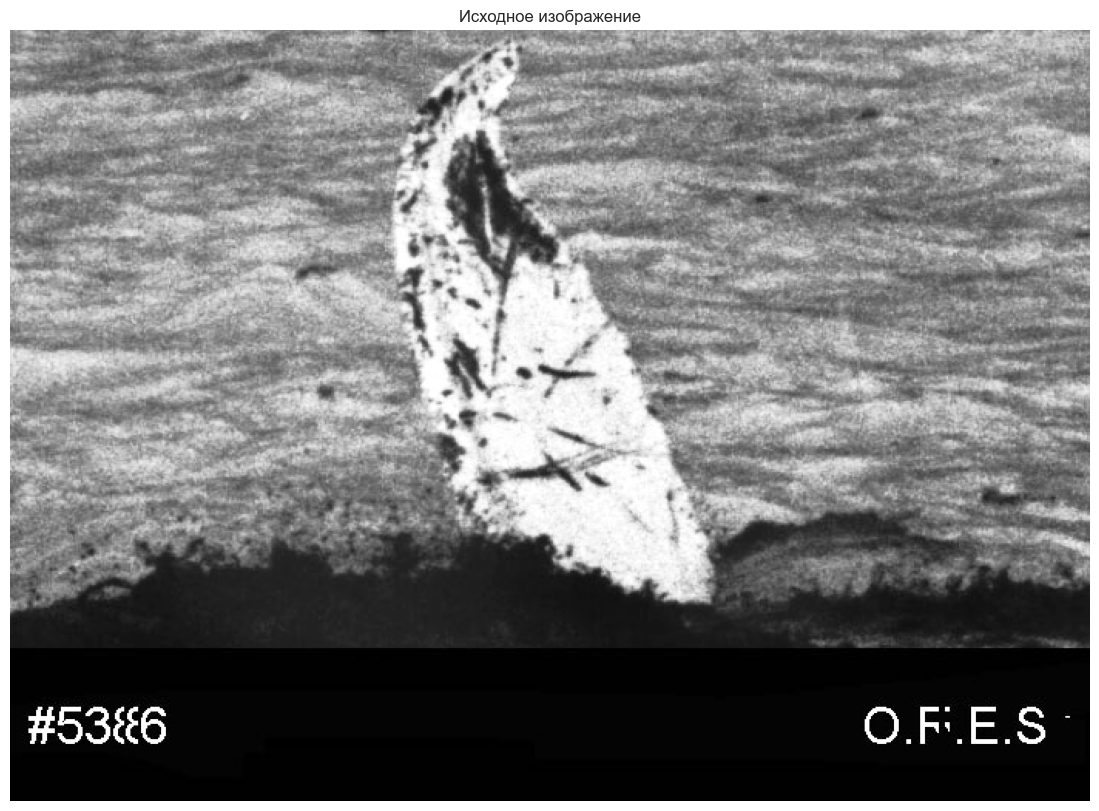

495 693


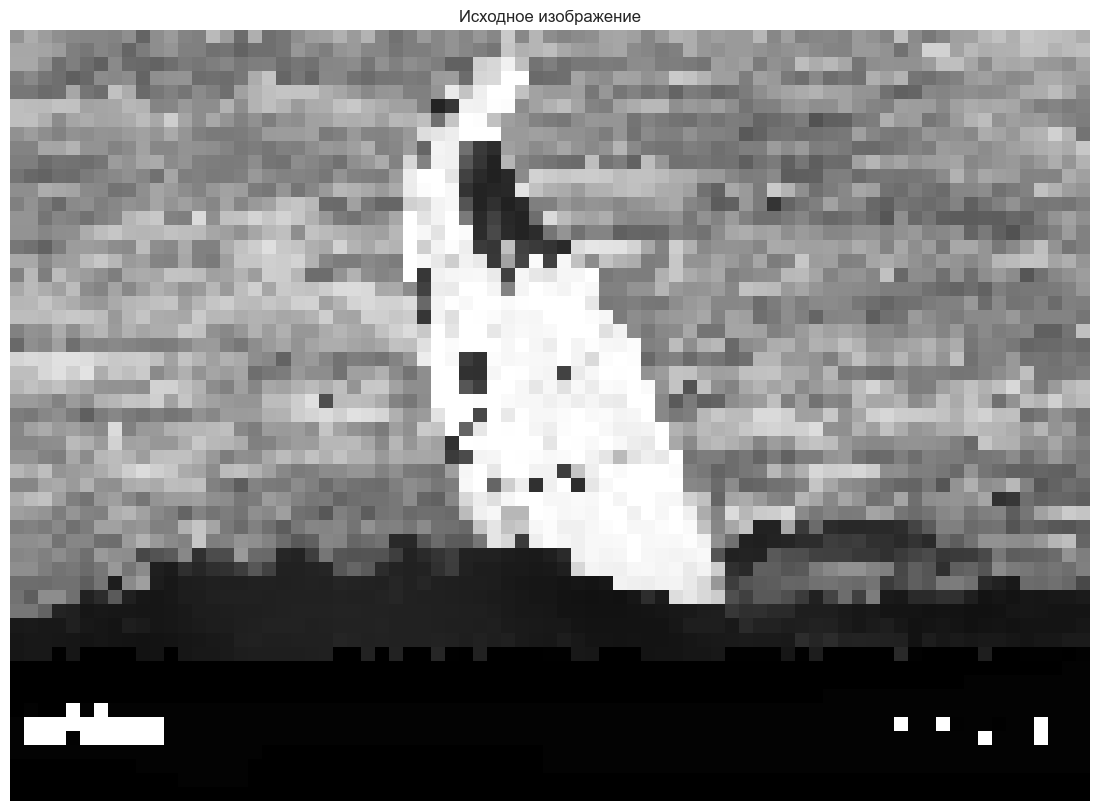

----------------


In [415]:
go_i(-1)

In [ ]:
def go(image):
    h, w, _ = image.shape
    image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
    print(h, w)
    # grayscale
#     gray = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)
    
    contours(image, count_gauss1 = 1, ksize1=3, g_threshold1 = 100, kresize = 1)

In [17]:
def go_i(num=-1):
    if num == -1:
        for i in range(0, 10):
            if i == 4 or i == 5:
                continue
            image = cv2.imread(f'whale_tail/test_image_0{i}.jpg')
            go(image)
            print("----------------")
        for i in range(10, 13):
            image = cv2.imread(f'whale_tail/test_image_{i}.jpg')
            go(image)
            print("----------------")
    else:
        if num < 10:
            image = cv2.imread(f'whale_tail/test_image_0{num}.jpg')
        else:
            image = cv2.imread(f'whale_tail/test_image_{num}.jpg')
        go(image)